In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
!nvidia-smi

Sat Nov  7 23:17:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:08:00.0  On |                  N/A |
| 26%   64C    P0    94W / 250W |   1765MiB / 12207MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # load our beautiful MINST data

In [4]:
train_images[0].shape

(28, 28)

In [5]:
type(train_images[0])

numpy.ndarray

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # reshape the 28x28 images into 
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
train_images.shape

(60000, 28, 28, 1)

In [8]:
type(train_images)

numpy.ndarray

In [9]:
# We changed the array from one image of 28x28 to one array which contains the entire dataset of 60,000 numbers , because it is small enough to fit into memory

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def make_generator_model():
    '''
    A Neural net generator which takes in some input and returns a 64x64 image color
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

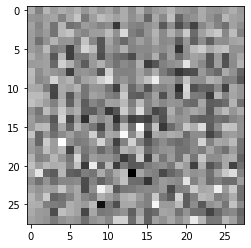

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100]) # generate an array of random numbers 
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision) # positive values are real image, negative values are fake images. The closer to zero the more unsure our model is 

tf.Tensor([[0.0017834]], shape=(1, 1), dtype=float32)


In [16]:
# currently our models have no idea what it is even looking at - because we have not trained it what is a real number and what is fake

In [17]:
# using binary crossentropy because we are optimizing for a binominal problem: 

# is the image input into the discriminator a real or a fake image?

# based on the loss given to the discriminator, how does it change how the generator would make new fake images to trick the discriminator?

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real_output, fake_output):
    '''
    Quantifies how weill the discriminator is able to distingish real and fake images
    
    Compares the discriminator's predictions on real images to an arrya of 1s
    
    predictions on fake images to an array of 0s
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def generator_loss(fake_output):
    '''
    Quantifies how well the generator is able to trick the discriminator
    
    If the generator generates an image that fools the discriminator, it is classified as 1
    '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
# We want to optimize the two neural networks separately 

generator_optimizer = tf.keras.optimizers.Adam(1e-4) # optimize for 1 to make fake images that look real 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) # optimize to identify as many fake images as possible

In [22]:
# define the training loop

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function # this one is a new way to do model.compile()
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [26]:
def train(dataset, epochs, previous_epochs=0):
    list_losses = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            losses = train_step(image_batch)
            list_losses.append(losses)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed, previous_epochs=0)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start) + '\n' 
               + 'Generator Loss: {} | Discriminator Loss: {}'.format(losses[0], losses[1]))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed, previous_epochs=0)
    return list_losses

In [27]:
def generate_and_save_images(model, epoch, test_input, previous_epochs=0):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        plt.suptitle(f'Generated Numbers at Epoch: {epoch+previous_epochs}', y=1)

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+previous_epochs))
    plt.show()

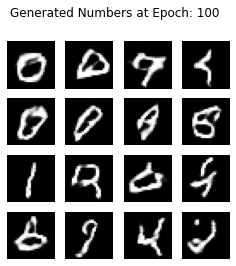

In [28]:
history = train(train_dataset, EPOCHS)

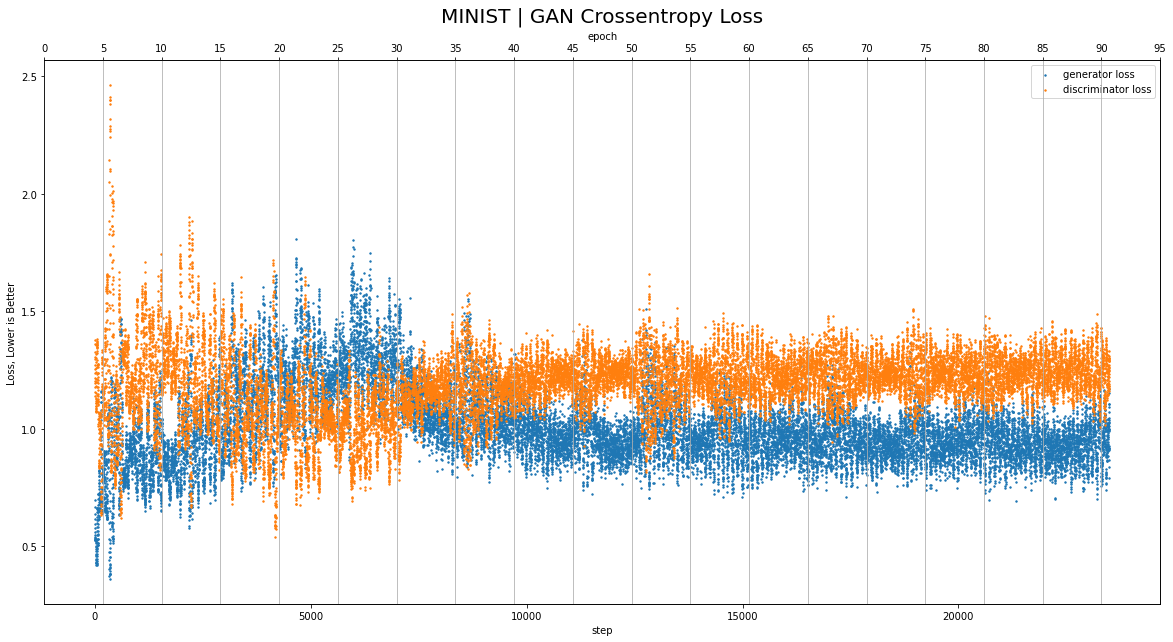

In [47]:
plt.figure(figsize=(20,10))
plt.scatter(x=range(len(history)), y=[float(i) for i,j in history], label='generator loss', s=2)
plt.scatter(x=range(len(history)), y=[float(j) for i,j in history], label='discriminator loss', s=2)
plt.title('MINIST | GAN Crossentropy Loss', fontsize=20, pad=10)
plt.ylabel('Loss, Lower is Better')
plt.legend()
axes1 = plt.gca()
axes2 = axes1.twiny()
axes2.set_xticks(range(0, EPOCHS, 5))
axes1.set_xlabel("step")
axes2.set_xlabel("epoch")
axes2.grid()

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


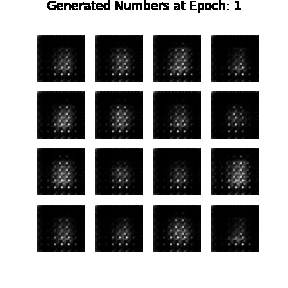

In [33]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)